In [1]:
"""
Decide gpu usage
"""
%env CUDA_VISIBLE_DEVICES=3
this_gpu_use_fraction = 0.5

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = this_gpu_use_fraction
set_session(tf.Session(config = config))


env: CUDA_VISIBLE_DEVICES=3


Using TensorFlow backend.


In [2]:
import numpy as np

from keras.models import load_model
from keras.applications.resnet50 import preprocess_input
from PIL import Image

import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import random
import os
import cv2
import scipy.misc
from matplotlib import pyplot as plt
import re
from math import ceil
import pandas as pd

K.set_learning_phase(0)

### load model & get layer (multi GPU ver.)

In [3]:
model = load_model('/home/seanyu/project/CCP/model/model_hard_negative_thresh10_gen2_k3.h5')
relu_out = K.function([model.get_layer('input_1').input],[model.get_layer('output').output, model.get_layer('activation_40').output])

In [4]:
test = pd.read_csv("/home/seanyu/project/CCP/res_csv/testing_hard_negative_thresh10_gen2_k3.csv")
posi_thres = 0.95
nega_thres = 0.5
fn = list(test[(test["y_true"] == 1) & (test["y_pred"] <= nega_thres)].sort_values("y_pred")["png_name"])
tn = list(test[(test["y_true"] == 0) & (test["y_pred"] <= nega_thres)].sort_values("y_pred")["png_name"])

fp = list(test[(test["y_true"] == 0) & (test["y_pred"] > posi_thres)].sort_values("y_pred", ascending = False)["png_name"])
tp = list(test[(test["y_true"] == 1) & (test["y_pred"] > posi_thres)].sort_values("y_pred", ascending = False)["png_name"])

In [5]:
def img_combine(img,ncols=5,size=1,path=False):
    nimg=len(img)
    nrows=int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))

    if nrows==0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth],cmap='rainbow')
            ax.set_axis_off()
    elif nrows==1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth],cmap='rainbow' )
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth],cmap='rainbow')
                ax.set_axis_off()
    
    if path:
        plt.savefig(path, dpi = 300)
    plt.show()

In [6]:
def op_img(x, crop_size, output_size):
        # crop size: w, h
        # output size, w, h, c
        crop_w, crop_h = crop_size
        out_w, out_h, out_c = output_size
        X_ = np.array([ np.array(img_center_crop(Image.open(i), 
                                                      target_size=(crop_w, crop_h)), dtype='float32') for i in x] )
        X_ = np.array([scipy.misc.imresize(i, size=(out_w, out_h)) for i in X_]) # add this line to resize images
        X_ = X_.reshape((len(X_), out_w, out_h, out_c))
        return X_
def img_center_crop(img, target_size):
    # return center cropprd image (not resizing)
    # img should be a PIL image object
    # target size should be a tuple, eg (224, 224)
    width, height = img.size
    if width <= target_size[0] and height <= target_size[1]:
        return img
    left = (width - target_size[0])/2
    right = (width + target_size[0])/2
    top = (height - target_size[1])/2
    bottom = (height + target_size[1])/2
    
    new_img = img.crop((left, top, right, bottom))
    return new_img

/data/put_data/seanyu/ccp/clean_date_cut/thres10/copper_test/300264140_2593.png
score: [ 0.94753873  0.05246127]
img


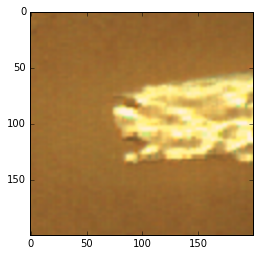

hotmap


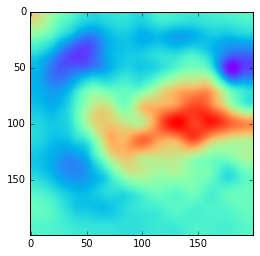

In [14]:
arr = []
suc = 0

force_binary = [1, 0]

import cv2
import re
for file in fn[:20]:
    o_img = cv2.imread(file).astype('float32')
    o_img = cv2.resize(o_img,(200,200))

    o_img = np.array(o_img).astype('uint8')

    in_img = op_img([file], (100,100), (200, 200, 3))
    in_img  = in_img.astype('float32')
    in_img = preprocess_input(in_img)
    
    result = relu_out([in_img])
    
    #output = result[0]
    #output = (result[0] > 0.5).astype(int)
    if force_binary:
        output = np.array([force_binary])
    else:
        output = result[0]
    #weight * filters
    filters = result[1]
    gap_w = np.dot(model.get_layer('output').get_weights()[0], np.swapaxes(output,0,1))
    
    gap_w = gap_w.reshape(1,1,1,1024)
    img = gap_w * filters
    img = img.sum(axis=3).reshape(filters.shape[1],filters.shape[2])
    img = cv2.resize(img,(200,200),interpolation=cv2.INTER_CUBIC)
    
    arr.append(o_img[:,:,::-1])
    arr.append(img)

    
    # show img
    print(file)
    print("score: "+str(result[0][0]))
    print("img")
    plt.figure()
    plt.imshow(o_img[:,:,::-1])
    plt.show()
    
    print("hotmap")
    plt.figure()
    plt.imshow(img,cmap='rainbow')
    plt.show()

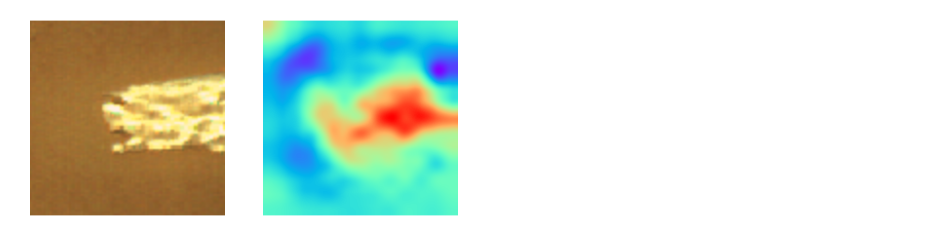

In [15]:
img_combine(arr, ncols=4, size=4, path="/home/seanyu/project/CCP/plots/heatmap_fn")